In [16]:
import os
from pathlib import Path
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, TargetEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Загрузка данных

In [17]:
path = str(Path(os.getcwd()).parent.absolute())
df = pd.read_pickle(path + '/data/train.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   battery_power  2000 non-null   int16   
 1   blue           2000 non-null   category
 2   clock_speed    2000 non-null   float16 
 3   dual_sim       2000 non-null   category
 4   fc             2000 non-null   int8    
 5   four_g         2000 non-null   category
 6   int_memory     2000 non-null   int8    
 7   m_dep          2000 non-null   float32 
 8   mobile_wt      2000 non-null   int16   
 9   n_cores        2000 non-null   int8    
 10  pc             2000 non-null   int8    
 11  px_height      2000 non-null   int16   
 12  px_width       2000 non-null   int16   
 13  ram            2000 non-null   int16   
 14  sc_h           2000 non-null   int8    
 15  sc_w           2000 non-null   int8    
 16  talk_time      2000 non-null   int8    
 17  three_g        2000 non-null   ca

# Формирование данных

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('price_range', axis=1), df['price_range'], test_size=0.25, random_state=42)

In [19]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

In [20]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

In [21]:
s_scaler = StandardScaler()
l_encoder = TargetEncoder() 
classifier = RandomForestClassifier()

In [22]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразованием

In [23]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model', RandomForestClassifier())])

In [24]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics

{'precision': 0.8666168807774647, 'recall': 0.868, 'f1': 0.8668418248726362}

In [25]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri) 

In [26]:
RUN_NAME = "baseline model"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

In [27]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [28]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = path + '/requirements.txt'

In [29]:
# Параметры, которые будут залогированы, можем задавать вручную или полностью взять из модели
params_dict = pipeline.get_params()

In [30]:
# Когда создаем новый эксперимент, то: 
EXPERIMENT_NAME = 'experiment_1'
# experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/23 15:21:20 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/2/runs/ee82d0e6360d4c09b4cdfae355194cfb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [31]:
mlflow.sklearn.autolog()

with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
    pipeline.fit(X_train, y_train)

2024/11/23 15:21:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/11/23 15:21:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/igorexy/Documents/IIS_LR1/

🏃 View run auto at: http://127.0.0.1:5000/#/experiments/2/runs/e24cfd0bb4b44404a3a966d28487530b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [32]:
mlflow.sklearn.autolog(disable=True)

In [33]:
classifier2 = RandomForestClassifier(n_estimators=10, max_depth=6)

In [34]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model',
                 RandomForestClassifier(max_depth=6, n_estimators=10))])

In [35]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics

{'precision': 0.7438184349763298, 'recall': 0.746, 'f1': 0.7447353652636671}

In [36]:
# !!! Проверить название прогона а также все логируемые параметры и артефакты, что они соответствуют второй "маленькой" модели. 

RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/2/runs/790d45c11642438dbda73ebd7ed51093
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [37]:
# No model
# Логировать можно только артефакты, без модели. Например, залогироавть графики после этапа EDA

RUN_NAME = 'no_model'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 


run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

🏃 View run no_model at: http://127.0.0.1:5000/#/experiments/2/runs/7e77e078fd37480b82a6ea6aae4e616c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [38]:
# Можно регистрировать сразу при создании прогона

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name='register_at_run', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME # Указываем для какой модели регистрируем
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'estate_model_rf' already exists. Creating a new version of this model...
2024/11/23 15:21:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 4


🏃 View run register_at_run at: http://127.0.0.1:5000/#/experiments/2/runs/cd85cc470f854037a3c21a2172768103
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


Created version '4' of model 'estate_model_rf'.


In [39]:
model_name = REGISTRY_MODEL_NAME
model_version = 1

model_loaded = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")

In [40]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [41]:
X_train_sklearn = X_train.copy()

In [42]:
pf = PolynomialFeatures(degree=2)

In [43]:
X_train_sklearn

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1738,511,0,0.899902,1,15,1,24,0.6,136,3,18,367,1264,2378,18,3,4,1,0,0
548,641,1,1.099609,0,0,1,7,0.9,192,1,3,417,759,3595,7,5,19,1,1,1
936,805,0,0.799805,0,1,0,34,0.6,88,6,2,1262,1538,3647,18,11,9,1,0,1
1389,1801,0,0.500000,1,6,0,52,0.9,120,6,10,100,1708,258,14,8,9,1,0,0
1607,744,0,1.700195,1,0,1,33,0.5,105,4,2,1252,1963,2700,9,3,19,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1975,1,1.900391,1,2,0,31,0.9,151,1,17,775,1607,3022,13,5,19,0,0,1
1294,589,1,0.500000,0,1,1,59,0.7,146,8,4,759,1858,362,16,10,6,1,1,1
860,1829,1,0.500000,0,0,1,15,0.4,160,5,7,729,1267,2080,16,11,12,1,0,1
1459,1927,0,0.899902,1,3,0,11,0.4,190,8,12,491,1506,2916,16,11,18,0,1,1


In [44]:
pf.fit_transform(X_train_sklearn[['m_dep','battery_power']])

array([[1.0000000e+00, 6.0000002e-01, 5.1100000e+02, 3.6000001e-01,
        3.0660001e+02, 2.6112100e+05],
       [1.0000000e+00, 8.9999998e-01, 6.4100000e+02, 8.0999994e-01,
        5.7689996e+02, 4.1088100e+05],
       [1.0000000e+00, 6.0000002e-01, 8.0500000e+02, 3.6000001e-01,
        4.8300003e+02, 6.4802500e+05],
       ...,
       [1.0000000e+00, 4.0000001e-01, 1.8290000e+03, 1.6000001e-01,
        7.3160004e+02, 3.3452410e+06],
       [1.0000000e+00, 4.0000001e-01, 1.9270000e+03, 1.6000001e-01,
        7.7079999e+02, 3.7133290e+06],
       [1.0000000e+00, 3.0000001e-01, 6.3500000e+02, 9.0000004e-02,
        1.9050000e+02, 4.0322500e+05]], dtype=float32)

In [45]:
sp = SplineTransformer(n_knots=3, degree=3)

In [46]:
sp.fit_transform(X_train_sklearn[['px_height']])

array([[0.04078983, 0.55268377, 0.39777316, 0.00875324, 0.        ],
       [0.03160063, 0.52412894, 0.43143002, 0.0128404 , 0.        ],
       [0.        , 0.06021945, 0.59577716, 0.34003222, 0.00397116],
       ...,
       [0.00280022, 0.31912659, 0.60946861, 0.06860458, 0.        ],
       [0.02070604, 0.47852865, 0.47980416, 0.02096114, 0.        ],
       [0.08631668, 0.63170091, 0.28070937, 0.00127304, 0.        ]])

In [47]:
qt = QuantileTransformer()

In [48]:
qt.fit_transform(X_train_sklearn[['px_height']])

array([[0.33024027],
       [0.37837838],
       [0.89289289],
       ...,
       [0.63113113],
       [0.44494494],
       [0.16916917]])

In [49]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [50]:
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [51]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,num_features),
        ('poly', pf_pipeline, ['m_dep', 'battery_power']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['px_height'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

In [52]:
X_train_sklearn[['m_dep', 'battery_power']] = X_train_sklearn[['m_dep', 'battery_power']].astype('float64')
X_train_sklearn[['m_dep', 'battery_power']] = X_train_sklearn[['m_dep', 'battery_power']].astype('float64')

In [53]:
X_train_sklearn

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1738,511.0,0,0.899902,1,15,1,24,0.6,136,3,18,367,1264,2378,18,3,4,1,0,0
548,641.0,1,1.099609,0,0,1,7,0.9,192,1,3,417,759,3595,7,5,19,1,1,1
936,805.0,0,0.799805,0,1,0,34,0.6,88,6,2,1262,1538,3647,18,11,9,1,0,1
1389,1801.0,0,0.500000,1,6,0,52,0.9,120,6,10,100,1708,258,14,8,9,1,0,0
1607,744.0,0,1.700195,1,0,1,33,0.5,105,4,2,1252,1963,2700,9,3,19,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1975.0,1,1.900391,1,2,0,31,0.9,151,1,17,775,1607,3022,13,5,19,0,0,1
1294,589.0,1,0.500000,0,1,1,59,0.7,146,8,4,759,1858,362,16,10,6,1,1,1
860,1829.0,1,0.500000,0,0,1,15,0.4,160,5,7,729,1267,2080,16,11,12,1,0,1
1459,1927.0,0,0.899902,1,3,0,11,0.4,190,8,12,491,1506,2916,16,11,18,0,1,1


In [54]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_sklearn, y_train)


In [55]:
X_train_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

In [56]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_sklearn)

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,num__ram,num__sc_h,num__sc_w,num__talk_time,cat__blue_0,cat__blue_1,cat__blue_2,cat__blue_3,cat__dual_sim_0,cat__dual_sim_1,cat__dual_sim_2,cat__dual_sim_3,cat__four_g_0,cat__four_g_1,cat__four_g_2,cat__four_g_3,cat__three_g_0,cat__three_g_1,cat__three_g_2,cat__three_g_3,cat__touch_screen_0,cat__touch_screen_1,cat__touch_screen_2,cat__touch_screen_3,cat__wifi_0,cat__wifi_1,cat__wifi_2,cat__wifi_3,quantile__battery_power,quantile__clock_speed,quantile__fc,quantile__int_memory,quantile__m_dep,quantile__mobile_wt,quantile__n_cores,quantile__pc,quantile__px_height,quantile__px_width,quantile__ram,quantile__sc_h,quantile__sc_w,quantile__talk_time,poly__1,poly__m_dep,poly__battery_power,poly__m_dep^2,poly__m_dep battery_power,poly__battery_power^2,spline__px_height_sp_0,spline__px_height_sp_1,spline__px_height_sp_2,spline__px_height_sp_3,spline__px_height_sp_4
0,-1.651710,-0.753173,2.460415,-0.454504,0.333786,-0.130677,-0.669214,1.343200,-0.618570,0.028575,0.234909,1.371934,-0.611770,-1.260437,0.261995,0.257043,0.253731,0.227228,0.222986,0.267191,0.244277,0.265541,0.239945,0.254428,0.249603,0.256023,0.237687,0.251919,0.260671,0.249723,0.217651,0.247519,0.279024,0.255798,0.250822,0.252494,0.255810,0.240873,0.011011,0.324324,0.972472,0.375876,0.596096,0.464464,0.303303,0.882382,0.330240,0.519019,0.575773,0.912412,0.328328,0.132633,0.0,0.333786,-1.651710,0.076802,-0.724335,-1.321423,0.040790,0.552684,0.397773,0.008753,0.0
1,-1.357394,-0.509571,-0.989195,-1.390605,1.378318,1.450771,-1.540208,-1.148308,-0.506253,-1.143163,1.360507,-1.236907,-0.152713,1.469094,0.247860,0.254700,0.242753,0.254687,0.264822,0.241108,0.259751,0.234316,0.225686,0.270453,0.250391,0.253467,0.233962,0.258972,0.258971,0.248094,0.256561,0.261501,0.248363,0.233573,0.232966,0.252914,0.247929,0.266189,0.104736,0.380881,0.000000,0.090591,0.898899,0.920921,0.000000,0.169169,0.378378,0.166000,0.888324,0.147648,0.515516,0.923924,0.0,1.378318,-1.357394,1.556298,-0.120832,-1.187072,0.031601,0.524129,0.431430,0.012840,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,1.554070,-0.753173,-0.299273,-1.170346,-0.362569,1.394291,1.508272,0.346596,-0.340024,0.590081,0.732503,0.897599,1.224458,1.287126,0.254413,0.259252,0.252819,0.233515,0.241049,0.252447,0.263826,0.242677,0.253870,0.250440,0.267677,0.228010,0.284571,0.270776,0.243090,0.201525,0.267175,0.263919,0.234456,0.234446,0.235600,0.266866,0.260285,0.237247,0.945297,0.324324,0.494494,0.165666,0.404404,0.905906,1.000000,0.611111,0.444945,0.675676,0.711087,0.752252,0.862863,0.869870,0.0,-0.362569,1.554070,-0.580751,0.312093,1.775585,0.020706,0.478529,0.479804,0.020961,0.0
1499,-1.370978,-1.118874,-0.759221,0.977179,-0.710746,-1.232042,0.201780,0.512697,-1.009433,-0.609500,-0.015737,0.186097,1.453987,0.195313,0.234905,0.250440,0.253885,0.260769,0.241049,0.252447,0.263826,0.242677,0.236728,0.259252,0.239956,0.264061,0.232469,0.250005,0.256575,0.260949,0.222070,0.245778,0.272847,0.259300,0.254621,0.242853,0.246218,0.256307,0.101917,0.229229,0.297798,0.783283,0.313814,0.138639,0.563063,0.656156,0.169169,0.321321,0.493493,0.547548,0.900901,0.557057,0.0,-0.710746,-1.370978,-0.810895,-0.983554,-1.193940,0.086317,0.631701,0.280709,0.001273,0.0


In [57]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', classifier)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

In [58]:
model_sklearn


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('model', RandomForestClassifier())])

In [59]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics

{'precision': 0.887857631627136, 'recall': 0.886, 'f1': 0.8863066189381978}

In [60]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'fe_sklearn'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/2/runs/5401fdb48ad346cc9ed0ac3a9d188f4f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [61]:
import sys
sys.modules.keys()

dict_keys(['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_distutils_hack', 'sitecustomize', 'site', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib._abc', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', 'types', '_functools', 'functools', '_weakrefset', 'threading', 'importlib.util', 'runpy', 'enum', '_sre', 're._constants', 're._parser', 're._casefix', 're._compiler', 'copyreg', 're', 'fnmatch', 'errno', 'urllib', 'math', 'ipaddress', 'urllib.parse', 'ntpath', 'pathlib', 'collections.abc', 'contextlib', '_typing', 'typing.io', 'typing.re', 'typing'

In [62]:
from autofeat import AutoFeatRegressor
transformations = ["1/", "exp", "log", "abs", "sqrt", "^2", "^3", "1+", "1-", "sin", "cos", "exp-", "2^"]

In [63]:
afreg = AutoFeatRegressor(verbose=1, feateng_steps=2, max_gb=8, transformations=["log", "sqrt"],feateng_cols=num_features)
X_train_arf = afreg.fit_transform(X_train,y_train)
X_train_arf

2024-11-23 15:21:28,731 INFO: [AutoFeat] The 2 step feature engineering process could generate up to 406 features.
2024-11-23 15:21:28,731 INFO: [AutoFeat] With 1500 data points this new feature matrix would use about 0.00 gb of space.
2024-11-23 15:21:28,733 INFO: [feateng] Step 1: transformation of original features


2024-11-23 15:21:29,617 INFO: [feateng] Generated 24 transformed features from 14 original features - done.
2024-11-23 15:21:29,620 INFO: [feateng] Step 2: first combination of features
2024-11-23 15:21:30,001 INFO: [feateng] Generated 703 feature combinations from 703 original feature tuples - done.


2024-11-23 15:21:30,006 INFO: [feateng] Generated altogether 731 new features in 2 steps
2024-11-23 15:21:30,007 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2024-11-23 15:21:30,025 INFO: [feateng] Generated a total of 500 additional features
2024-11-23 15:21:30,085 INFO: [featsel] Feature selection run 1/5


[featsel] Scaling data...done.


2024-11-23 15:21:34,438 INFO: [featsel] Feature selection run 2/5
2024-11-23 15:21:37,924 INFO: [featsel] Feature selection run 3/5
2024-11-23 15:21:42,726 INFO: [featsel] Feature selection run 4/5
2024-11-23 15:21:46,592 INFO: [featsel] Feature selection run 5/5
2024-11-23 15:21:50,820 INFO: [featsel] 178 features after 5 feature selection runs
/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:
2024-11-23 15:21:50,893 INFO: [featsel] 107 features after correlation filtering
2024-11-23 15:21:51,431 INFO: [featsel] 11 features after noise filtering
2024-11-23 15:21:51,432 INFO: [AutoFeat] Computing 9 new features.


2024-11-23 15:21:52,442 INFO: [AutoFeat]     9/    9 new features ...done.
2024-11-23 15:21:52,444 INFO: [AutoFeat] Final dataframe with 29 feature columns (9 new).
2024-11-23 15:21:52,444 INFO: [AutoFeat] Training final regression model.


2024-11-23 15:21:52,473 INFO: [AutoFeat] Trained model: largest coefficients:
2024-11-23 15:21:52,475 INFO: -1.2044959863943754
2024-11-23 15:21:52,476 INFO: 0.000900 * ram
2024-11-23 15:21:52,477 INFO: -0.000455 * m_dep*mobile_wt
2024-11-23 15:21:52,478 INFO: -0.000441 * sqrt(clock_speed)*mobile_wt
2024-11-23 15:21:52,480 INFO: 0.000194 * battery_power
2024-11-23 15:21:52,481 INFO: 0.000096 * sqrt(battery_power)*sqrt(px_height)
2024-11-23 15:21:52,482 INFO: 0.000042 * px_height*log(n_cores)
2024-11-23 15:21:52,482 INFO: 0.000020 * sqrt(pc)*px_height
2024-11-23 15:21:52,482 INFO: 0.000017 * sqrt(int_memory)*px_height
2024-11-23 15:21:52,484 INFO: [AutoFeat] Final score: 0.9153


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,wifi,px_width*ram,battery_power*ram,sqrt(pc)*px_height,sqrt(battery_power)*sqrt(px_height),sqrt(clock_speed)*mobile_wt,battery_power*sqrt(px_width),sqrt(int_memory)*px_height,m_dep*mobile_wt,px_height*log(n_cores)
0,511.0,0.0,0.899902,1.0,15.0,1.0,24.0,0.6,136.0,3.0,...,0.0,3005792.0,1215158.0,1557.049132,433.055424,129.013929,18167.469389,1797.925471,81.600003,403.190710
1,641.0,1.0,1.099609,0.0,0.0,1.0,7.0,0.9,192.0,1.0,...,1.0,2728605.0,2304395.0,722.265187,517.007737,201.335541,17659.520916,1103.278297,172.799995,0.000000
2,805.0,0.0,0.799805,0.0,1.0,0.0,34.0,0.6,88.0,6.0,...,1.0,5609086.0,2935835.0,1784.737516,1007.923608,78.699984,31569.961197,7358.661291,52.800002,2261.200450
3,1801.0,0.0,0.500000,1.0,6.0,0.0,52.0,0.9,120.0,6.0,...,0.0,440664.0,464658.0,316.227766,424.381903,84.852814,74431.649908,721.110255,107.999997,179.175947
4,744.0,0.0,1.700195,1.0,0.0,1.0,33.0,0.5,105.0,4.0,...,0.0,5300100.0,2008800.0,1770.595380,965.136260,136.911115,32963.482340,7192.192433,52.500000,1735.640540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1975.0,1.0,1.900391,1.0,2.0,0.0,31.0,0.9,151.0,1.0,...,1.0,4856354.0,5968450.0,3195.406860,1237.184303,208.160531,79172.623899,4315.017381,135.899996,0.000000
1496,589.0,1.0,0.500000,0.0,1.0,1.0,59.0,0.7,146.0,8.0,...,1.0,672596.0,213218.0,1518.000000,668.618725,103.237590,25388.564709,5829.989623,102.199998,1578.296130
1497,1829.0,1.0,0.500000,0.0,0.0,1.0,15.0,0.4,160.0,5.0,...,1.0,2635360.0,3804320.0,1928.752706,1154.703858,113.137085,65103.151590,2823.404859,64.000001,1173.280238
1498,1927.0,0.0,0.899902,1.0,3.0,0.0,11.0,0.4,190.0,8.0,...,1.0,4391496.0,5619132.0,1700.873893,972.706019,180.240047,74781.504893,1628.462772,76.000001,1021.005797


In [64]:
class AutoFeatWrapper():
    def __init__(self, feateng_cols, feateng_steps=1, max_gb=16, transformations=["1/", "exp", "log"], n_jobs=-1, verbose=1):
        self.feateng_cols = feateng_cols
        self.feateng_steps = feateng_steps
        self.max_gb = max_gb
        self.transformations = transformations
        self.n_jobs = n_jobs
        self.afreg = AutoFeatRegressor(feateng_cols=self.feateng_cols,
                                     feateng_steps=self.feateng_steps,
                                     max_gb=self.max_gb,
                                     transformations=self.transformations,
                                     n_jobs=self.n_jobs)
        
    def fit(self, X, y=None):
        self.afreg.fit(X, y)
        return self
    
    def transform(self, X):
        return self.afreg.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        # Преобразуем данные и возвращаем имена фичей из DataFrame
        transformed_X = self.afreg.transform(pd.DataFrame(np.zeros((1, len(self.feateng_cols))), columns=self.feateng_cols))
        return transformed_X.columns.tolist()

In [65]:
afreg_pipeline = Pipeline(steps=[
    ('autofeat', AutoFeatWrapper( feateng_steps=2, max_gb=16, transformations=["log", "sqrt"],feateng_cols=num_features)),
    ('scaler', StandardScaler()),
])

In [66]:
preprocessor_afr = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('afr', afreg_pipeline, num_features), # преобразования autofeat
    ],
    remainder='drop', # Удаляем столбцы, которые не затронуты преобразованиями
    ) 

In [67]:
X_train_afr_raw =  preprocessor_afr.fit_transform(X_train,y_train)
X_train_afr = pd.DataFrame(X_train_afr_raw, columns=preprocessor_afr.get_feature_names_out())

/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


In [68]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_afr)

    

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,num__ram,num__sc_h,num__sc_w,num__talk_time,cat__blue_0,cat__blue_1,cat__blue_2,cat__blue_3,cat__dual_sim_0,cat__dual_sim_1,cat__dual_sim_2,cat__dual_sim_3,cat__four_g_0,cat__four_g_1,cat__four_g_2,cat__four_g_3,cat__three_g_0,cat__three_g_1,cat__three_g_2,cat__three_g_3,cat__touch_screen_0,cat__touch_screen_1,cat__touch_screen_2,cat__touch_screen_3,cat__wifi_0,cat__wifi_1,cat__wifi_2,cat__wifi_3,afr__battery_power,afr__clock_speed,afr__fc,afr__int_memory,afr__m_dep,afr__mobile_wt,afr__n_cores,afr__pc,afr__px_height,afr__px_width,afr__ram,afr__sc_h,afr__sc_w,afr__talk_time,afr__px_width*ram,afr__battery_power*ram,afr__sqrt(pc)*px_height,afr__sqrt(battery_power)*sqrt(px_height),afr__sqrt(clock_speed)*mobile_wt,afr__battery_power*sqrt(px_width),afr__sqrt(n_cores)*ram,afr__sqrt(int_memory)*px_height
0,-1.651710,-0.753173,2.460415,-0.454504,0.333786,-0.130677,-0.669214,1.343200,-0.618570,0.028575,0.234909,1.371934,-0.611770,-1.260437,0.244187,0.260788,0.260785,0.234239,0.227446,0.254839,0.258057,0.259656,0.232874,0.263145,0.240849,0.263130,0.234403,0.247544,0.262859,0.255193,0.218945,0.250422,0.266975,0.263652,0.254590,0.246245,0.256276,0.242887,-1.651710,-0.753173,2.460415,-0.454504,0.333786,-0.130677,-0.669214,1.343200,-0.618570,0.028575,0.234909,1.371934,-0.611770,-1.260437,0.201913,-0.828125,-0.198026,-1.050472,-0.562296,-1.430188,-0.089052,-0.591646
1,-1.357394,-0.509571,-0.989195,-1.390605,1.378318,1.450771,-1.540208,-1.148308,-0.506253,-1.143163,1.360507,-1.236907,-0.152713,1.469095,0.243246,0.256754,0.238200,0.261798,0.264670,0.245690,0.257778,0.231858,0.239625,0.265159,0.241233,0.253982,0.235952,0.256889,0.256887,0.250272,0.271476,0.254967,0.240087,0.233465,0.235609,0.269466,0.235622,0.259300,-1.357394,-0.509571,-0.989195,-1.390605,1.378318,1.450771,-1.540208,-1.148308,-0.506253,-1.143163,1.360507,-1.236907,-0.152713,1.469094,0.039496,-0.190297,-0.733871,-0.821743,0.528867,-1.459197,-0.289737,-0.837684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,1.554070,-0.753173,-0.299273,-1.170346,-0.362569,1.394291,1.508272,0.346596,-0.340024,0.590081,0.732503,0.897599,1.224458,1.287126,0.260629,0.257373,0.255734,0.226261,0.240657,0.263401,0.240670,0.255270,0.257473,0.252209,0.262770,0.227545,0.289197,0.245455,0.245450,0.219871,0.259843,0.261502,0.245079,0.233573,0.238589,0.255498,0.252117,0.253795,1.554070,-0.753173,-0.299273,-1.170346,-0.362569,1.394291,1.508272,0.346596,-0.340024,0.590081,0.732503,0.897599,1.224458,1.287126,1.013860,1.750726,-0.105705,0.419812,0.210586,1.803050,1.492798,-0.651669
1499,-1.370978,-1.118875,-0.759221,0.977179,-0.710746,-1.232042,0.201780,0.512697,-1.009433,-0.609500,-0.015737,0.186097,1.453987,0.195313,0.241504,0.263589,0.251703,0.243203,0.234928,0.257743,0.249598,0.257730,0.232578,0.255811,0.254262,0.257347,0.235241,0.254923,0.261479,0.248357,0.224659,0.246269,0.271184,0.257884,0.260340,0.247109,0.250419,0.242130,-1.370978,-1.118874,-0.759221,0.977179,-0.710746,-1.232042,0.201780,0.512697,-1.009433,-0.609500,-0.015737,0.186097,1.453987,0.195313,-0.338311,-0.756225,-0.750813,-1.276543,-1.375097,-1.327262,0.137975,-0.745085


In [69]:
pipeline_afr = Pipeline(steps=[('preprocessor', preprocessor_afr), 
                               ('model', classifier)])

pipeline_afr.fit(X_train, y_train)

/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('afr',
                                                  Pipeline(steps=[('autofeat',
                                                                   <__main__.AutoFeatWrapper object at 0x7cccd52d8f20>),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time'])])),
                ('model', RandomForestClassifier())])

In [70]:
X_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1860,1646,0,2.500000,0,3,1,25,0.6,200,2,5,211,1608,686,8,6,11,1,1,0
353,1182,0,0.500000,0,7,1,8,0.5,138,8,16,275,986,2563,19,17,19,1,0,0
1333,1972,0,2.900391,0,9,0,14,0.4,196,7,18,293,952,1316,8,1,8,1,1,0
905,989,1,2.000000,0,4,0,17,0.2,166,3,19,256,1394,3892,18,7,19,1,1,0
1289,615,1,0.500000,1,7,0,58,0.5,130,5,8,1021,1958,1906,14,5,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,733,0,2.099609,0,5,1,7,0.2,174,7,10,445,1409,1403,15,8,2,1,1,0
1356,1021,0,1.299805,0,7,0,9,0.7,192,2,12,901,1793,1355,6,1,14,1,1,0
408,1504,0,1.500000,0,12,1,34,0.7,142,8,15,507,973,2806,7,2,7,1,0,1
1614,1001,0,2.800781,1,1,0,40,0.2,117,3,7,922,1836,3654,13,9,10,1,1,1


In [71]:
predictions = pipeline_afr.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics

{'precision': 0.9223696519160401, 'recall': 0.92, 'f1': 0.920264623511049}

In [72]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name='autofeat', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline_afr, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(pipeline_afr.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

🏃 View run autofeat at: http://127.0.0.1:5000/#/experiments/2/runs/b0fd6813ffa94e408afb805ec9e4b918
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [73]:
from sklearn.feature_selection import RFE
X_train_afr

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,...,afr__sc_w,afr__talk_time,afr__px_width*ram,afr__battery_power*ram,afr__sqrt(pc)*px_height,afr__sqrt(battery_power)*sqrt(px_height),afr__sqrt(clock_speed)*mobile_wt,afr__battery_power*sqrt(px_width),afr__sqrt(n_cores)*ram,afr__sqrt(int_memory)*px_height
0,-1.651710,-0.753173,2.460415,-0.454504,0.333786,-0.130677,-0.669214,1.343200,-0.618570,0.028575,...,-0.611770,-1.260437,0.201913,-0.828125,-0.198026,-1.050472,-0.562296,-1.430188,-0.089052,-0.591646
1,-1.357394,-0.509571,-0.989195,-1.390605,1.378318,1.450771,-1.540208,-1.148308,-0.506253,-1.143163,...,-0.152713,1.469094,0.039496,-0.190297,-0.733871,-0.821743,0.528867,-1.459197,-0.289737,-0.837684
2,-0.986103,-0.875272,-0.759221,0.096143,0.333786,-1.486203,0.637277,-1.314409,1.391904,0.664330,...,1.224458,-0.350593,1.727302,0.179458,-0.051874,0.515762,-1.321415,-0.664769,1.755462,1.377914
3,1.268810,-1.240973,0.390649,1.087309,1.378318,-0.582519,0.637277,0.014395,-1.218342,1.058776,...,0.535873,-0.350593,-1.301113,-1.267599,-0.994505,-1.074103,-1.228583,1.783070,-1.424930,-0.973044
4,-1.124205,0.223023,-0.989195,0.041078,-0.014391,-1.006121,-0.233717,-1.314409,1.369440,1.650446,...,-0.611770,1.469094,1.546253,-0.363390,-0.060951,0.399188,-0.443146,-0.585185,0.401793,1.318952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1.662740,0.467221,-0.529247,-0.069051,1.378318,0.292926,-1.540208,1.177099,0.297936,0.824429,...,-0.152713,1.469094,1.286242,1.955277,0.853630,1.140385,0.631840,2.053828,-0.509264,0.299884
1496,-1.475121,-1.240973,-0.759221,1.472762,0.681963,0.151725,1.508272,-0.982208,0.261995,1.406817,...,0.994930,-0.896499,-1.165213,-1.414835,-0.223091,-0.408677,-0.951200,-1.017790,-1.274777,0.836473
1497,1.332201,-1.240973,-0.989195,-0.950087,-0.362569,0.547087,0.201780,-0.483906,0.194605,0.035536,...,1.224458,0.195313,-0.015140,0.688020,0.040569,0.915666,-0.801840,1.250318,0.114845,-0.228431
1498,1.554070,-0.753173,-0.299273,-1.170346,-0.362569,1.394291,1.508272,0.346596,-0.340024,0.590081,...,1.224458,1.287126,1.013860,1.750726,-0.105705,0.419812,0.210586,1.803050,1.492798,-0.651669


In [74]:
rfe_selector = RFE(estimator=classifier, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_rfe = rfe_selector.fit_transform(X_train_afr,y_train)

In [75]:
X_train_afr_rfe = pd.DataFrame(X_train_rfe, columns=rfe_selector.get_feature_names_out())
X_train_afr_rfe

,num__battery_power,num__ram,afr__battery_power,afr__px_height,afr__px_width,afr__ram,afr__px_width*ram,afr__battery_power*ram,afr__sqrt(battery_power)*sqrt(px_height),afr__battery_power*sqrt(px_width),afr__sqrt(n_cores)*ram,afr__sqrt(int_memory)*px_height
0,-1.651710,0.234909,-1.651710,-0.618570,0.028575,0.234909,0.201913,-0.828125,-1.050472,-1.430188,-0.089052,-0.591646
1,-1.357394,1.360507,-1.357394,-0.506253,-1.143163,1.360507,0.039496,-0.190297,-0.821743,-1.459197,-0.289737,-0.837684
2,-0.986103,1.408602,-0.986103,1.391903,0.664330,1.408602,1.727302,0.179458,0.515762,-0.664769,1.755462,1.377914
3,1.268810,-1.725869,1.268810,-1.218342,1.058776,-1.725869,-1.301113,-1.267599,-1.074103,1.783070,-1.424930,-0.973044
4,-1.124205,0.532726,-1.124205,1.369440,1.650446,0.532726,1.546253,-0.363390,0.399188,-0.585185,0.401793,1.318952
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1.662740,0.830542,1.662740,0.297936,0.824429,0.830542,1.286242,1.955277,1.140385,2.053828,-0.509264,0.299884
1496,-1.475121,-1.629680,-1.475121,0.261995,1.406817,-1.629680,-1.165213,-1.414835,-0.408677,-1.017790,-1.274777,0.836473
1497,1.332201,-0.040710,1.332201,0.194605,0.035536,-0.040710,-0.015140,0.688020,0.915666,1.250318,0.114845,-0.228431
1498,1.554070,0.732503,1.554070,-0.340024,0.590081,0.732503,1.013860,1.750726,0.419812,1.803050,1.492798,-0.651669


In [76]:
rfe_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_afr), 
    ('rfe_extractor', RFE(estimator=classifier, n_features_to_select=12, step = 0.2)),
    ('model', classifier)
])

rfe_pipeline.fit(X_train, y_train)

/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('afr',
                                                  Pipeline(steps=[('autofeat',
                                                                   <__main__.AutoFeatWrapper object at 0x7cccd52d8f20>),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time'])])),
                ('rfe_extractor',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=12, step=0.2)),
                ('model', RandomForestClassifier())])

In [77]:
predictions_rfe = rfe_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_rfe, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_rfe, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_rfe, average='weighted')

metrics

{'precision': 0.9262028105850599, 'recall': 0.924, 'f1': 0.9242315138227027}

In [78]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(rfe_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/2/runs/381731039bae4df4af0c62c8c674e1f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [79]:
rfe_skl_selector = RFE(estimator=classifier, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_sklearn,y_train)

In [80]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

,num__battery_power,num__px_height,num__px_width,num__ram,quantile__battery_power,quantile__px_height,quantile__px_width,quantile__ram,poly__battery_power,poly__battery_power^2,spline__px_height_sp_1,spline__px_height_sp_3
0,-1.651710,-0.618570,0.028575,0.234909,0.011011,0.330240,0.519019,0.575773,-1.651710,-1.321423,0.552684,0.008753
1,-1.357394,-0.506253,-1.143163,1.360507,0.104736,0.378378,0.166000,0.888324,-1.357394,-1.187072,0.524129,0.012840
2,-0.986103,1.391903,0.664330,1.408602,0.213213,0.892893,0.695696,0.901919,-0.986103,-0.974328,0.060219,0.340032
3,1.268810,-1.218342,1.058776,-1.725869,0.861927,0.077389,0.804644,0.000000,1.268810,1.354188,0.656786,0.000177
4,-1.124205,1.369440,1.650446,0.532726,0.174132,0.887908,0.970971,0.661662,-1.124205,-1.059095,0.062845,0.333269
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1.662740,0.297936,0.824429,0.830542,0.980981,0.655771,0.738892,0.743263,1.662740,1.943610,0.288561,0.082428
1496,-1.475121,0.261995,1.406817,-1.629680,0.068068,0.646647,0.899900,0.030687,-1.475121,-1.244451,0.299115,0.077428
1497,1.332201,0.194605,0.035536,-0.040710,0.882883,0.631131,0.520521,0.485623,1.332201,1.445370,0.319127,0.068605
1498,1.554070,-0.340024,0.590081,0.732503,0.945297,0.444945,0.675676,0.711087,1.554070,1.775585,0.478529,0.020961


In [81]:
rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__battery_power',
 'num__px_height',
 'num__px_width',
 'num__ram',
 'quantile__battery_power',
 'quantile__px_height',
 'quantile__px_width',
 'quantile__ram',
 'poly__battery_power',
 'poly__battery_power^2',
 'spline__px_height_sp_1',
 'spline__px_height_sp_3']

In [82]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
        True, False, False,  True, False,  True, False,  True, False])

In [83]:
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [84]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    f
    def fit(self, X, y=None):
        return self

In [85]:
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_skl_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7ccd17c509e0>),
                ('model', RandomForestClassifier())])

In [86]:
predictions_rfe_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_rfe_skl, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_rfe_skl, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_rfe_skl, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(rfe_skl_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

🏃 View run rfe_skl_feature_selection at: http://127.0.0.1:5000/#/experiments/2/runs/f7a9a2696dc94499b5875b6a4a7b7b61
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [87]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [88]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='f1_weighted',
                                cv=2)

sfs.fit(X_train_sklearn,y_train)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=3),
                          k_features=(3, 3), scoring='f1_weighted')

In [89]:
selected_features_sfs = X_train_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__ram,poly__battery_power,spline__px_height_sp_4
0,0.234909,-1.651710,0.000000
1,1.360507,-1.357394,0.000000
2,1.408602,-0.986103,0.003971
3,-1.725869,1.268810,0.000000
4,0.532726,-1.124205,0.003564
...,...,...,...
1495,0.830542,1.662740,0.000000
1496,-1.629680,-1.475121,0.000000
1497,-0.040710,1.332201,0.000000
1498,0.732503,1.554070,0.000000


In [90]:
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['num__ram', 'poly__battery_power', 'spline__px_height_sp_4']

In [91]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx

[10, 54, 62]

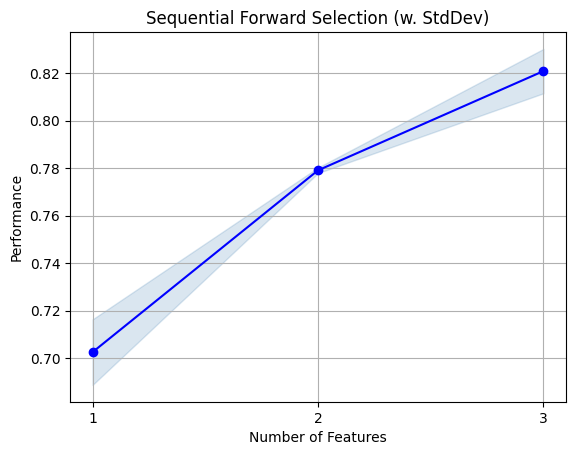

In [92]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [93]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', classifier)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7cccc22b20f0>),
                ('model', RandomForestClassifier())])

In [94]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_sfs, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_sfs, average='weighted')
metrics["f1"] = f1_score(y_test, predictions_sfs, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(rfe_sfs_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

🏃 View run rfe_sfs_feature_selection at: http://127.0.0.1:5000/#/experiments/2/runs/45fe9e8aea484c0ead9541ec65af9298
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [95]:
from sklearn.model_selection import  GridSearchCV

In [96]:
param_grid = {
    'model__max_depth': [i for i in range(1,10)],
    'model__n_estimators': [i for i in range(1,5)],
    'model__max_features': [i/10 for i in range(1,10)]
}

In [97]:
gs = GridSearchCV(rfe_skl_pipeline, param_grid, cv=2, scoring='f1_weighted')
gs.fit(X_train, y_train)
print("Лучшие гиперпараметры:", gs.best_params_)

/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (750). n_quantiles is set to n_samples.
  warnings.warn(
/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (750). n_quantiles is set to n_samples.
  warnings.warn(
/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (750). n_quantiles is set to n_samples.
  warnings.warn(
/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (750). n_quantiles is set to n_samples.
  warnings.warn(
/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site

Лучшие гиперпараметры: {'model__max_depth': 9, 'model__max_features': 0.7, 'model__n_estimators': 4}


/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (750). n_quantiles is set to n_samples.
  warnings.warn(
/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [98]:
classifier_optimized = RandomForestClassifier(max_depth=7, max_features=0.8, n_estimators=4)
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier_optimized)
])

rfe_skl_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7ccd170a7ef0>),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=0.8,
                                        n_estimators=4))])

In [99]:
predictions_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_skl, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_skl, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_skl, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection_optimased_GridSearch'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME # Указываем для какой модели регистрируем
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(rfe_skl_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'estate_model_rf' already exists. Creating a new version of this model...
2024/11/23 15:22:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 5


🏃 View run rfe_skl_feature_selection_optimased_GridSearch at: http://127.0.0.1:5000/#/experiments/2/runs/bd7f159f115b4eb5baaf2b26851aefd4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


Created version '5' of model 'estate_model_rf'.


In [101]:
import optuna

/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [102]:
def objective(trial):
    # предлагаем гиперпараметры
    depth = trial.suggest_int('depth', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', RandomForestClassifier())
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    f1 =  f1_score(y_test, preds,  average='weighted')   

    return f1

In [103]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2024-11-23 15:25:11,384] A new study created in memory with name: no-name-4562752d-aab3-4433-beec-6f06efe89e2d
[I 2024-11-23 15:25:11,606] Trial 0 finished with value: 0.8436078700249673 and parameters: {'depth': 5, 'learning_rate': 0.032067745977680986}. Best is trial 0 with value: 0.8436078700249673.
[I 2024-11-23 15:25:11,818] Trial 1 finished with value: 0.837762337776993 and parameters: {'depth': 8, 'learning_rate': 0.02575355437348662}. Best is trial 1 with value: 0.837762337776993.
[I 2024-11-23 15:25:12,029] Trial 2 finished with value: 0.8359954084671669 and parameters: {'depth': 5, 'learning_rate': 0.09817527557023215}. Best is trial 2 with value: 0.8359954084671669.
[I 2024-11-23 15:25:12,245] Trial 3 finished with value: 0.8355723624975533 and parameters: {'depth': 10, 'learning_rate': 0.06037934995840922}. Best is trial 3 with value: 0.8355723624975533.
[I 2024-11-23 15:25:12,469] Trial 4 finished with value: 0.8296438901116817 and parameters: {'depth': 4, 'learning_rat

Number of finished trials: 10
Best trial: {'depth': 3, 'learning_rate': 0.04856756883232071}


In [104]:
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', RandomForestClassifier())
])

opt_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7cccc2214bf0>),
                ('model', RandomForestClassifier())])

In [105]:
optuna_model = opt_pipeline.predict(X_test)


metrics = {}
metrics["precision"] = precision_score(y_test, optuna_model, average='weighted')   
metrics["recall"] = recall_score(y_test, optuna_model, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, optuna_model, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna_model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME # Указываем для какой модели регистрируем
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(opt_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'estate_model_rf' already exists. Creating a new version of this model...
2024/11/23 15:25:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 6


🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/2/runs/f97fb8fcfe8b446a8aff1957cfd8e02d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


Created version '6' of model 'estate_model_rf'.


In [108]:
df = pd.read_pickle(path + "/data/train.pkl")
df = df.rename(columns={'price_range': 'target'})

In [109]:
Y = df['target']
X = df.drop('target', axis=1)

In [111]:
rfe_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_afr), 
    ('rfe_extractor', RFE(estimator=classifier, n_features_to_select=12, step = 0.2)),
    ('model', classifier)
])

rfe_pipeline.fit(X, Y)
rfe_pipeline.predict(X)

/home/igorexy/Documents/IIS_LR1/venv/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


array([1, 2, 2, ..., 3, 0, 3])

In [112]:
predictions_rfe = rfe_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_rfe, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_rfe, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_rfe, average='weighted')

metrics

{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [115]:
EXPERIMENT_NAME='experiment_1'
REGISTRY_MODEL_NAME = "estate_model_rf"

In [116]:
# Самая лучшая модель
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(rfe_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'estate_model_rf' already exists. Creating a new version of this model...
2024/11/23 15:27:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 7


🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/2/runs/542d03a28f6b465fa07070011e4928a8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


Created version '7' of model 'estate_model_rf'.


In [117]:
run_id

'542d03a28f6b465fa07070011e4928a8'